<a href="https://colab.research.google.com/github/sachi-jh/BBT_LegalDuel_1C/blob/main/BTT_Legal_Duel1C_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2" # suppress info and warning messages
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras as keras
import nltk
import spacy
#import enchant it saying enchant isnt a module??
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Exploratory Data Analysis
The following data shows RecordID, Label, extractedComment, extractedResponse, filingData, Sentiment, SentimentScore, and the Website link to the filings.

*Note: Label column is not the actual label of the model. The predictive label is Sentiment (Neutral, Accept, Reject). The feature is extractedResponse

May predict the Label/Topic column in the future

In [ ]:
filename = os.path.join(os.getcwd(),  '/content/drive/MyDrive/AML/SentimentAnalysis.csv')
df = pd.read_csv(filename, header = 0)

In [ ]:
df.head(10)

,RecordID,Label,extractedComment,extractedResponse,filingDate,Sentiment,SentimentScore,Website
0,96362,Past performance and Benchmark,Comment: The Advisors Inner Circle Fund - West...,"Response 5 The Fund agrees, and going forward,...",20160427,Neutral,1,https:www.sec.gov/Archives/edgar/data/890540/0...
1,96364,High Yield and Junk Bonds,Comment: The Advisors Inner Circle Fund - West...,Response 6 When appropriate and subject to ava...,20160427,Accept,2,https:www.sec.gov/Archives/edgar/data/890540/0...
2,96364,Maturity and Duration,Comment: The Advisors Inner Circle Fund - West...,Response 6 When appropriate and subject to ava...,20160427,Accept,2,https:www.sec.gov/Archives/edgar/data/890540/0...
3,108491,Website,Comment: The staff noted the prospectus for Th...,"Response 3 The Funds agree, and going forward,...",20160427,Accept,2,https:www.sec.gov/Archives/edgar/data/890540/0...
4,108493,Market Capitalization,Comment: The staff noted the prospectus for Th...,"Response 7 The Fund agrees, and going forward,...",20160427,Neutral,1,https:www.sec.gov/Archives/edgar/data/890540/0...
5,108493,Website,Comment: The staff noted the prospectus for Th...,"Response 7 The Fund agrees, and going forward,...",20160427,Neutral,1,https:www.sec.gov/Archives/edgar/data/890540/0...
6,108495,Website,Comment: The staff noted the prospectus for Th...,"Response 10 The Fund agrees, and going forward...",20160427,Neutral,1,https:www.sec.gov/Archives/edgar/data/890540/0...
7,44795,Past performance and Benchmark,Comment: For the average annual total return t...,"Response 9 The Funds agree, and going forward,...",20160427,Neutral,1,https:www.sec.gov/Archives/edgar/data/1593547/...
8,43115,Code of Ethics,Comment: For The Advisors Inner Circle Fund II...,"Response 8 The Trusts agree, and in future N-C...",20160427,Neutral,1,https:www.sec.gov/Archives/edgar/data/1593547/...
9,43115,High Yield and Junk Bonds,Comment: For The Advisors Inner Circle Fund II...,"Response 8 The Trusts agree, and in future N-C...",20160427,Neutral,1,https:www.sec.gov/Archives/edgar/data/1593547/...


In [ ]:
print(df.columns)

Index(['RecordID', 'Label', 'extractedComment', 'extractedResponse',
       'filingDate', 'Sentiment', 'SentimentScore', 'Website'],
      dtype='object')


In [ ]:
df.shape

(10000, 8)

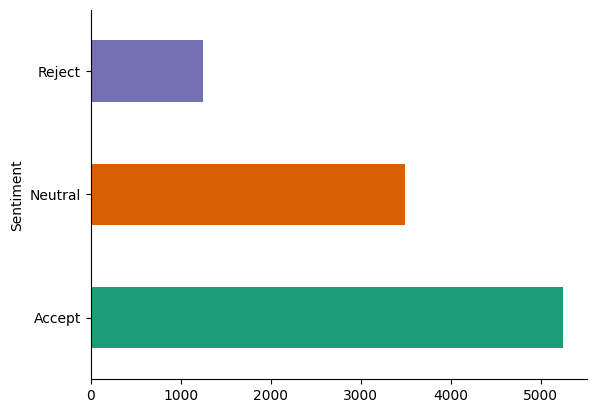

In [ ]:
# @title Sentiment

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
df.isnull().values.any()

True

In [ ]:
nan_count = np.sum(df.isnull(), axis = 0)
nan_count

,0
RecordID,0
Label,0
extractedComment,0
extractedResponse,275
filingDate,0
Sentiment,0
SentimentScore,0
Website,0


The next steps would be to remove the rows with null values.

In [ ]:
df = df.dropna(subset=['extractedResponse'])
nan_count = np.sum(df.isnull(), axis = 0)
nan_count

,0
RecordID,0
Label,0
extractedComment,0
extractedResponse,0
filingDate,0
Sentiment,0
SentimentScore,0
Website,0


In [ ]:
df = df.drop('Website', axis=1)
df = df.dropna(how='any',axis=0)
print(df.columns)

Index(['RecordID', 'Label', 'extractedComment', 'extractedResponse',
       'filingDate', 'Sentiment', 'SentimentScore'],
      dtype='object')


It probably also makes sense to remove the website column since I don't think it will necessarily be predictive.

In [ ]:
#df.columns = [x.lower() for x in data.columns] could potentially normalize the caps if we want

# potential way to remove the rows with strange strings?

#def is_english(text):
    #words_in_text = text.split()
   # return all(word.lower() in english_words for word in words_in_text)

#df_filtered = df[df.apply(is_english, axis=1)]


AAnonymous has rows with unidentifiable language - Exact number TBD. Cleans up and removes those rows with gibberish wordings.

In [ ]:
import re
def is_gibberish(text):
    return bool(re.search(r'[^a-zA-Z\s]', text))
df_cleaned = df[~df['extractedResponse'].apply(is_gibberish)]
print(df_cleaned.head())

      RecordID                 Label  \
4701     15975            Borrowings   
4702     15975     Expense Liability   
4703     15975         Inconsistency   
4713     16054  Completed fee tables   
4714     16054     Expense Liability   

                                       extractedComment extractedResponse  \
4701  Comment:  FUND SUMMARY  FEES AND EXPENSESOF TH...        RESPONSETO   
4702  Comment:  FUND SUMMARY  FEES AND EXPENSESOF TH...        RESPONSETO   
4703  Comment:  FUND SUMMARY  FEES AND EXPENSESOF TH...        RESPONSETO   
4713  Comment:  FUND SUMMARY  PRINCIPAL INVESTMENTST...        RESPONSETO   
4714  Comment:  FUND SUMMARY  PRINCIPAL INVESTMENTST...        RESPONSETO   

      filingDate Sentiment  SentimentScore  
4701    20160620   Neutral               1  
4702    20160620   Neutral               1  
4703    20160620   Neutral               1  
4713    20160620   Neutral               1  
4714    20160620   Neutral               1  


## Training Data Preparation

In [ ]:
X = df["extractedResponse"]
y = df["Sentiment"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1234)

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(X_train)
X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
vocabulary_size = len(tfidf_vectorizer.vocabulary_)
print(vocabulary_size)

26865


In [ ]:
nn_model = keras.Sequential()

input_layer = keras.layers.InputLayer(input_shape=(vocabulary_size,))
nn_model.add(input_layer)


hidden_layer_1 = keras.layers.Dense(units = 64, activation='relu')
nn_model.add(hidden_layer_1)

hidden_layer_2 = keras.layers.Dense(units = 32, activation='relu')
nn_model.add(hidden_layer_2)

hidden_layer_3 = keras.layers.Dense(units = 16, activation='relu')
nn_model.add(hidden_layer_3)

output_layer = keras.layers.Dense(units = 1, activation = 'sigmoid')
nn_model.add(output_layer)

nn_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
sgd_optimizer = keras.optimizers.SGD(learning_rate = 0.1)

In [ ]:
loss_fn = keras.losses.BinaryCrossentropy(from_logits = False)

In [ ]:
nn_model.compile(optimizer=sgd_optimizer, loss=loss_fn, metrics=['accuracy'])

In [ ]:
class ProgBarLoggerNEpochs(keras.callbacks.Callback):
  def __init__(self, num_epochs: int, every_n: int = 50):
    self.num_epochs = num_epochs
    self.every_n = every_n
  def on_epoch_end(self, epoch, logs=None):
    if (epoch + 1) % self.every_n == 0:
      s = 'Epoch [{}/ {}]'.format(epoch + 1, self.num_epochs)
      logs_s = ['{}: {:.4f}'.format(k.capitalize(), v)
                for k, v in logs.items()]
      s_list = [s] + logs_s
      print(', '.join(s_list))

In [ ]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_train = keras.utils.to_categorical(y_train, num_classes=3)

In [ ]:
t0 = time.time()
num_epochs = 50

history = nn_model.fit(
  X_train_tfidf.toarray().astype(np.float32) ,
  y_train_encoded,
  epochs=num_epochs,
  validation_split=0.2,
  verbose=0,
  callbacks=[ProgBarLoggerNEpochs(num_epochs, every_n=5)],
)
t1 = time.time() # stop time
print('Elapsed time: %.2fs' % (t1-t0))

Epoch [5/ 50], Accuracy: 0.5351, Loss: 128.6866, Val_accuracy: 0.5497, Val_loss: 121.0662
Epoch [10/ 50], Accuracy: 0.5351, Loss: 96.0184, Val_accuracy: 0.5497, Val_loss: 89.5276
Epoch [15/ 50], Accuracy: 0.5351, Loss: 63.3175, Val_accuracy: 0.5497, Val_loss: 57.9653
Epoch [20/ 50], Accuracy: 0.5351, Loss: 30.6737, Val_accuracy: 0.5497, Val_loss: 26.4267
Epoch [25/ 50], Accuracy: 0.4086, Loss: 0.7713, Val_accuracy: 0.3235, Val_loss: 0.6815
Epoch [30/ 50], Accuracy: 0.3320, Loss: 0.6745, Val_accuracy: 0.3235, Val_loss: 0.6821
Epoch [35/ 50], Accuracy: 0.3320, Loss: 0.6744, Val_accuracy: 0.3235, Val_loss: 0.6835
Epoch [40/ 50], Accuracy: 0.3320, Loss: 0.6742, Val_accuracy: 0.3235, Val_loss: 0.6844
Epoch [45/ 50], Accuracy: 0.3320, Loss: 0.6745, Val_accuracy: 0.3235, Val_loss: 0.6815
Epoch [50/ 50], Accuracy: 0.3320, Loss: 0.6746, Val_accuracy: 0.3235, Val_loss: 0.6819
Elapsed time: 156.62s
